In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

from sklearn import feature_selection as fs

from sklearn import metrics

import sklearn.decomposition as skde

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier

from sklearn import svm

%matplotlib inline

In [2]:
# Split dataset
Features = np.array(pd.read_csv('../PreparedData/BikeBuyerFeatures.csv'))
Labels = np.array(pd.read_csv('../PreparedData/BikeBuyerLabels.csv'))

index = ms.train_test_split(range(Features.shape[0]), test_size=round(0.3*Features.shape[0]))
X_train = Features[index[0], :]
y_train = np.ravel(Labels[index[0]])
X_test = Features[index[1], :]
y_test = np.ravel(Labels[index[1]])

In [3]:
# Evaluation
def scoring_model(probs, threshold):
    # compute the positive (1) predictions
    return [1 if prob > threshold else 0 for prob in probs[:, 1]]

def print_metrics(labels, scores):
    conf = sklm.confusion_matrix(labels, scores)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    acc = sklm.accuracy_score(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0][0] + '             %5d' % conf[0][1])
    print('Actual negative    %6d' % conf[1][0] + '             %5d' % conf[1][1])
    print('')
    print('Accuracy  %0.2f' % acc)
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1]) 
    
def plot_auc(labels, probs):
    # Compute the false positive rate, true positive rate and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    # Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def print_cv(clf, params_grid, param = 'C'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())  
    # print(keys)
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter (AUC)')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))

In [4]:
# Nested cross validation
def nested_cross_val(estimator, param_grid, features, labels, n_splits, scoring='roc_auc'):
    inside = ms.KFold(n_splits=n_splits, shuffle=True)
    outside = ms.KFold(n_splits=n_splits, shuffle=True)
    
    estimator = ms.GridSearchCV(estimator=estimator, param_grid=param_grid,
                               cv=inside, scoring=scoring, return_train_score=True)
    estimator.fit(features, labels)
    
    cv_estimate = ms.cross_val_score(estimator=estimator, X=features, y=labels, cv=outside)
    
    print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
    print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
    print('Outcomes by cv fold')
    for i, x in enumerate(cv_estimate):
        print('Fold %2d    %4.3f' % (i+1, x))
        
    return estimator, estimator.best_estimator_  

# Logistic Rregression Model

In [5]:
## Construct logistic regression model
logistic_clf = linear_model.LogisticRegression().fit(X_train, y_train)
probs = logistic_clf.predict_proba(X_test)

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2906               357
Actual negative       711               947

Accuracy  0.78
 
           Positive      Negative
Num case     3263          1658
Precision    0.80          0.73
Recall       0.89          0.57
F1           0.84          0.64


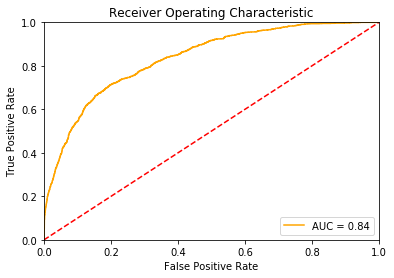

In [6]:
## Score and evaluate the model
scores = scoring_model(probs, 0.5)
print_metrics(y_test, scores)
plot_auc(y_test, probs)

### Use a weighted model for imbalanced labels

In [7]:
## Compute a weighted model for imbalanced data
logistic_clf_weighted = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}).fit(X_train, y_train)
probs_weighted = logistic_clf_weighted.predict_proba(X_test)

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2818               445
Actual negative       613              1045

Accuracy  0.79
 
           Positive      Negative
Num case     3263          1658
Precision    0.82          0.70
Recall       0.86          0.63
F1           0.84          0.66


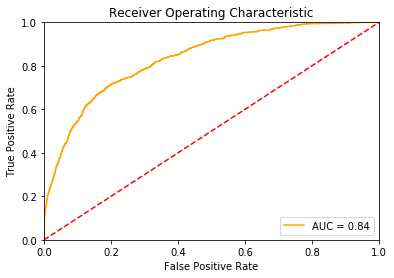

In [8]:
# Exmaine the weighted model
scores = scoring_model(probs_weighted, 0.5)
print_metrics(y_test, scores)
plot_auc(y_test, probs_weighted)

### Find a better threshold

In [9]:
thresholds = [0.60, 0.55, 0.5, 0.45, 0.40, 0.35]
def test_threshold(probs, labels, threshold):
    scores = scoring_model(probs, threshold)
    print('')
    print('For threshold = ' + str(threshold))
    print_metrics(labels, scores)

for t in thresholds:
    # test_threshold(probabilities, y_test, t)
    test_threshold(probs_weighted, y_test, t)


For threshold = 0.6
                 Confusion matrix
                 Score positive    Score negative
Actual positive      2966               297
Actual negative       781               877

Accuracy  0.78
 
           Positive      Negative
Num case     3263          1658
Precision    0.79          0.75
Recall       0.91          0.53
F1           0.85          0.62

For threshold = 0.55
                 Confusion matrix
                 Score positive    Score negative
Actual positive      2904               359
Actual negative       714               944

Accuracy  0.78
 
           Positive      Negative
Num case     3263          1658
Precision    0.80          0.72
Recall       0.89          0.57
F1           0.84          0.64

For threshold = 0.5
                 Confusion matrix
                 Score positive    Score negative
Actual positive      2818               445
Actual negative       613              1045

Accuracy  0.79
 
           Positive      Negative
Num case

## Feature Selection
### Eliminate low variance features

In [10]:
# Remove features with low variance (variance threshold set to .8 * (1 - .8)))
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(Features)
# Print the support and shape for the transformed features
print(sel.get_support())
print(Features_reduced.shape)

[ True False False  True False False False False  True  True  True  True
  True  True  True  True  True  True  True False False  True False False
 False False False  True False False False False False  True]
(16404, 16)


### Select some best features

In [11]:
# Reshape the Label array
Labels = Labels.reshape(Labels.shape[0],)
# Set folds for nested cross validation
feature_folds = ms.KFold(n_splits=10, shuffle = True)
# Define the model
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 

# Perform feature selection by CV with high variance features only
selector = fs.RFECV(estimator = logistic_mod, cv = feature_folds,
                      scoring = 'roc_auc').fit(Features_reduced, Labels)
selector.support_ , selector.ranking_

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [12]:
Features_reduced = selector.transform(Features_reduced)
Features_reduced.shape

(16404, 16)

Text(0.5, 0, 'Number of features')

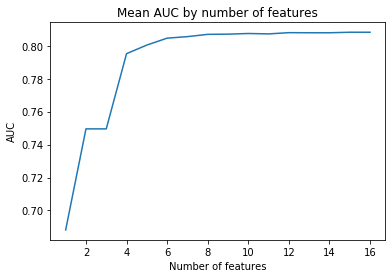

In [13]:
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.title('Mean AUC by number of features')
plt.ylabel('AUC')
plt.xlabel('Number of features')

### Apply nested cross validation to create model

In [15]:
# Define the dictionary for the grid search and the model object to search on
param_grid = {"C": [0.1, 1, 10, 100, 1000]}
# Define the logistic regression model
n_splits = 10
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 

logistic_mod, best_estimator = nested_cross_val(logistic_mod, param_grid, Features_reduced, Labels, n_splits)
print('best estimator:')
print(best_estimator.C)

Mean performance metric = 0.808
SDT of the metric       = 0.012
Outcomes by cv fold
Fold  1    0.804
Fold  2    0.823
Fold  3    0.801
Fold  4    0.810
Fold  5    0.796
Fold  6    0.832
Fold  7    0.804
Fold  8    0.807
Fold  9    0.791
Fold 10    0.815
best estimator:
0.1


In [16]:
print_cv(logistic_mod, param_grid) 

Performance metrics by parameter (AUC)
Parameter   Mean performance   STD performance
    0.10        0.80844            0.00684
    1.00        0.80838            0.00687
   10.00        0.80836            0.00689
  100.00        0.80835            0.00689
 1000.00        0.80835            0.00689


### Conclusion

The best estimator for parameter 'C' is 0.1

## Dimensionality Reduction
### Principle Components

In [17]:
pca_mod = skde.PCA()
pca_comps = pca_mod.fit(X_train)
print(pca_comps.explained_variance_ratio_)
print(np.sum(pca_comps.explained_variance_ratio_))

[2.09118201e-01 1.07746318e-01 8.02897195e-02 6.97447391e-02
 5.99927882e-02 5.30775266e-02 4.72315665e-02 4.28729743e-02
 4.11976953e-02 3.56858547e-02 3.32005389e-02 2.97076654e-02
 2.49007225e-02 2.38658462e-02 2.20314117e-02 2.01272336e-02
 1.86733378e-02 1.63092231e-02 1.35583623e-02 1.23062124e-02
 1.07380087e-02 7.54727769e-03 6.75759445e-03 6.06288099e-03
 3.93191963e-03 3.32438112e-03 5.41666053e-32 1.01361625e-32
 4.73214272e-33 2.03481309e-33 1.22955883e-33 1.13165506e-33
 1.13165506e-33 5.92284540e-35]
1.0


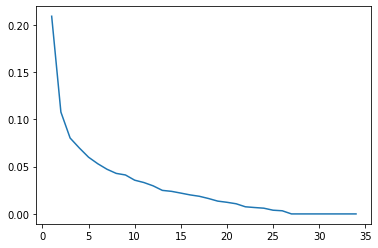

In [18]:
# Plot the importance curve for each feature
def plot_explained(mod):
    comps = mod.explained_variance_ratio_
    x = range(len(comps))
    x = [y + 1 for y in x]          
    plt.plot(x,comps)

plot_explained(pca_comps)

### Compute and evaluate a logistic regression model  using  5 components

In [19]:
# Trains and fits a PCA model with 5 selected components 
pca_mod_5 = skde.PCA(n_components = 5).fit(X_train)
Comps = pca_mod_5.transform(X_train)
Comps_test = pca_mod_5.transform(X_test)
Comps.shape

(11483, 5)

In [20]:
# Define and fit the logistic regression model using the first five components
log_mod_5 = linear_model.LogisticRegression(C = 0.1, class_weight = {0:0.45, 1:0.55}).fit(Comps, y_train)
probs_5 = log_mod_5.predict_proba(Comps_test)

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2906               357
Actual negative       711               947

Accuracy  0.78
 
           Positive      Negative
Num case     3263          1658
Precision    0.80          0.73
Recall       0.89          0.57
F1           0.84          0.64


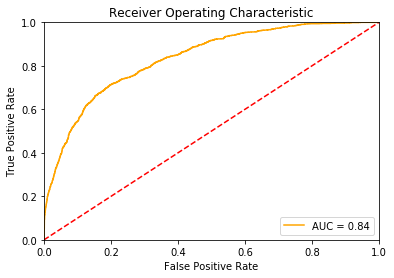

In [21]:
scores = scoring_model(probs, 0.5)
print_metrics(y_test, scores)
plot_auc(y_test, probs)

### Add more components to the model

In [22]:
pca_mod_10 = skde.PCA(n_components = 10).fit(X_train)
Comps_10 = pca_mod_10.transform(X_train)
Comps_10_test = pca_mod_10.transform(X_test)

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2728               535
Actual negative       756               902

Accuracy  0.74
 
           Positive      Negative
Num case     3263          1658
Precision    0.78          0.63
Recall       0.84          0.54
F1           0.81          0.58


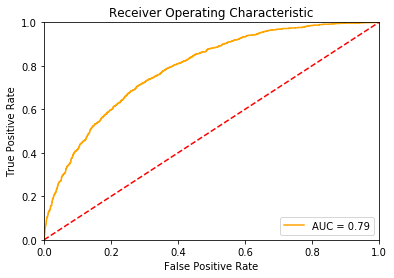

In [23]:
log_mod_10 = linear_model.LogisticRegression(C = 0.1, class_weight = {0:0.45, 1:0.55}).fit(Comps_10, y_train)
probs_10 = log_mod_10.predict_proba(Comps_10_test)
scores = scoring_model(probs_10, 0.5)
print_metrics(y_test, scores)   
plot_auc(y_test, probs_10) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2795               468
Actual negative       683               975

Accuracy  0.77
 
           Positive      Negative
Num case     3263          1658
Precision    0.80          0.68
Recall       0.86          0.59
F1           0.83          0.63


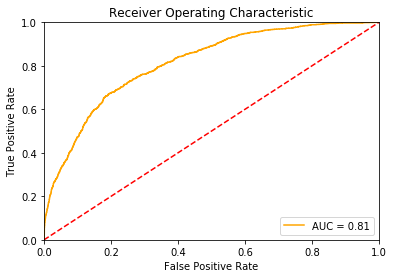

In [24]:
pca_mod_15 = skde.PCA(n_components = 15).fit(X_train)
Comps_15 = pca_mod_15.transform(X_train)
Comps_15_test = pca_mod_15.transform(X_test)

log_mod_15 = linear_model.LogisticRegression(C = 0.1, class_weight = {0:0.45, 1:0.55}).fit(Comps_15, y_train)
probs_15 = log_mod_15.predict_proba(Comps_15_test)
scores = scoring_model(probs_15, 0.5)
print_metrics(y_test, scores)     
plot_auc(y_test, probs_15) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2798               465
Actual negative       670               988

Accuracy  0.77
 
           Positive      Negative
Num case     3263          1658
Precision    0.81          0.68
Recall       0.86          0.60
F1           0.83          0.64


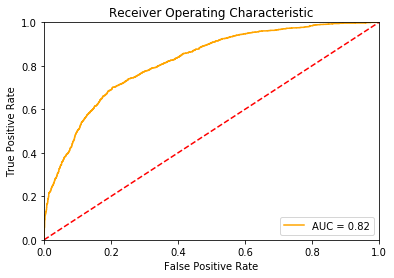

In [25]:
pca_mod_20 = skde.PCA(n_components = 20).fit(X_train)
Comps_20 = pca_mod_20.transform(X_train)
Comps_20_test = pca_mod_20.transform(X_test)

log_mod_20 = linear_model.LogisticRegression(C = 0.1, class_weight = {0:0.45, 1:0.55}).fit(Comps_20, y_train)
probs_20 = log_mod_20.predict_proba(Comps_20_test)
scores = scoring_model(probs_20, 0.5)
print_metrics(y_test, scores)  
plot_auc(y_test, probs_20)

### Evaluate the number of components by using cross validation

In [26]:
def print_format(f,x,y,z):
    print('Fold %2d    %4.3f        %4.3f      %4.3f' % (f, x, y, z))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall       AUC')
    [print_format(f,x,y,z) for f,x,y,z in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'],
                                          scores['test_roc_auc'])]
    print('-' * 40)
    print('Mean       %4.3f        %4.3f      %4.3f' % 
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro']), np.mean(scores['test_roc_auc'])))  
    print('Std        %4.3f        %4.3f      %4.3f' % 
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro']), np.std(scores['test_roc_auc'])))

    
Labels = Labels.reshape(Labels.shape[0],)
scoring = ['precision_macro', 'recall_macro', 'roc_auc']

In [27]:
pca_mod = skde.PCA(n_components = 5)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_5, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores)

         Precision     Recall       AUC
Fold  1    0.692        0.672      0.757
Fold  2    0.683        0.679      0.749
Fold  3    0.687        0.656      0.756
Fold  4    0.666        0.662      0.734
Fold  5    0.719        0.696      0.798
Fold  6    0.684        0.673      0.750
Fold  7    0.694        0.669      0.766
Fold  8    0.723        0.684      0.773
Fold  9    0.713        0.687      0.763
Fold 10    0.707        0.690      0.778
----------------------------------------
Mean       0.697        0.677      0.762
Std        0.017        0.012      0.017


In [28]:
pca_mod = skde.PCA(n_components = 10)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_10, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores) 

         Precision     Recall       AUC
Fold  1    0.703        0.687      0.784
Fold  2    0.711        0.706      0.791
Fold  3    0.700        0.686      0.789
Fold  4    0.697        0.699      0.778
Fold  5    0.730        0.718      0.816
Fold  6    0.698        0.688      0.787
Fold  7    0.720        0.698      0.799
Fold  8    0.740        0.704      0.792
Fold  9    0.715        0.699      0.783
Fold 10    0.708        0.699      0.789
----------------------------------------
Mean       0.712        0.698      0.791
Std        0.013        0.009      0.010


In [29]:
pca_mod = skde.PCA(n_components = 15)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_10, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores) 

         Precision     Recall       AUC
Fold  1    0.712        0.700      0.799
Fold  2    0.728        0.721      0.813
Fold  3    0.729        0.718      0.807
Fold  4    0.734        0.726      0.809
Fold  5    0.759        0.745      0.840
Fold  6    0.741        0.728      0.819
Fold  7    0.751        0.725      0.826
Fold  8    0.740        0.709      0.810
Fold  9    0.741        0.721      0.807
Fold 10    0.731        0.717      0.814
----------------------------------------
Mean       0.737        0.721      0.814
Std        0.012        0.011      0.011


In [30]:
pca_mod = skde.PCA(n_components = 20)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_10, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores) 

         Precision     Recall       AUC
Fold  1    0.722        0.712      0.808
Fold  2    0.737        0.730      0.818
Fold  3    0.745        0.739      0.819
Fold  4    0.751        0.745      0.818
Fold  5    0.762        0.750      0.841
Fold  6    0.756        0.745      0.830
Fold  7    0.766        0.742      0.832
Fold  8    0.749        0.714      0.815
Fold  9    0.739        0.723      0.809
Fold 10    0.745        0.731      0.825
----------------------------------------
Mean       0.747        0.733      0.822
Std        0.012        0.013      0.010


### Conclusion
After Computing PCA models with different numbers of components and comparing logistic regression models with different numbers of components, I find that use 15 components produced a significantly better model. Using 15 components is a useful reduction in dimensionality compared to the original 34 features.

# Random Forest Model

In [31]:
rf_clf = RandomForestClassifier(class_weight='balanced')

In [32]:
# Use the nested cross validation to find better parameters for the model
param_grid = {'max_features': [2, 3, 5, 10, 15], 'min_samples_leaf':[3, 5, 10, 20]}
n_splits = 10
rf_clf, best_estimator_ = nested_cross_val(rf_clf, param_grid, Features, Labels, n_splits)
print('best estimator:')
print(best_estimator.C)

'''
It shows that the model can give a good generalizaiton to the data
If using Features:
max_features = 10
min_samples_leaf = 20
Mean performance metric = 0.850
SDT of the metric       = 0.006

If using Features_reduced:
max_features = 5
min_samples_leaf = 10
Mean performance metric = 0.849
SDT of the metric       = 0.008
'''

Mean performance metric = 0.848
SDT of the metric       = 0.010
Outcomes by cv fold
Fold  1    0.837
Fold  2    0.836
Fold  3    0.851
Fold  4    0.841
Fold  5    0.852
Fold  6    0.865
Fold  7    0.855
Fold  8    0.860
Fold  9    0.850
Fold 10    0.834
best estimator:
0.1


'\nIt shows that the model can give a good generalizaiton to the data\nIf using Features:\nmax_features = 10\nmin_samples_leaf = 20\nMean performance metric = 0.850\nSDT of the metric       = 0.006\n\nIf using Features_reduced:\nmax_features = 5\nmin_samples_leaf = 10\nMean performance metric = 0.849\nSDT of the metric       = 0.008\n'

### Use the best parameters to test the performance

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2528               735
Actual negative       423              1235

Accuracy  0.76
 
           Positive      Negative
Num case     3263          1658
Precision    0.86          0.63
Recall       0.77          0.74
F1           0.81          0.68


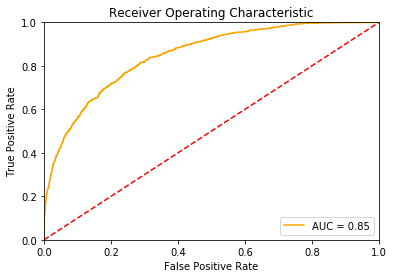

In [33]:
rf_mod = RandomForestClassifier(class_weight='balanced',
                               max_features=best_estimator_.max_features,
                               min_samples_leaf=best_estimator_.min_samples_leaf)
rf_mod.fit(X_train, y_train)
probs = rf_mod.predict_proba(X_test)
print_metrics(y_test, scoring_model(probs, 0.5))
plot_auc(y_test, probs)
# AUC = 0.85

# AdaBoost Model

In [52]:
ab_clf = AdaBoostClassifier()

In [53]:
param_grid = {'learning_rate': [0.1, 1, 10]}
n_splits = 10
ab_clf, best_estimator_ = nested_cross_val(ab_clf, param_grid, Features, Labels, n_splits)
print('best estimator:')
print(best_estimator_.learning_rate)

Mean performance metric = 0.834
SDT of the metric       = 0.010
Outcomes by cv fold
Fold  1    0.840
Fold  2    0.827
Fold  3    0.851
Fold  4    0.848
Fold  5    0.832
Fold  6    0.841
Fold  7    0.833
Fold  8    0.817
Fold  9    0.832
Fold 10    0.825
best estimator:
1


### Use the best parameters to test the performance

In [ ]:
ab_mod = AdaBoostClassifier(learning_rate=best_estimator_.learning_rate)
ab_mod.fit(X_train, y_train)
probs = ab_mod.predict_proba(X_test)
print_metrics(y_test, scoring_model(probs, 0.5))
plot_auc(y_test, probs)
# The majority of negative class have been misclassified as positive
# because of the class imbalanced
# AdaBoost classifier is sensitive to imbalanced data

### Deal with the impact of imbalanced data by undersampling}

In [41]:
Labels = Labels.reshape(Labels.shape[0],)
## Randomize the undersampling to create a data set with balanced cases
temp_Labels_1 = Labels[Labels == 1] # save these
temp_Features_1 = Features[Labels == 1, :]  # save these
temp_Labels_0 = Labels[Labels == 0] # undersample these
temp_Features_0 = Features[Labels == 0, :]  # undersmaple these
# Undersampling
index = nr.choice(temp_Features_0.shape[0], temp_Features_1.shape[0],
                 replace=True)
temp_Features = np.concatenate((temp_Features_1, temp_Features_0[index,:]),
                              axis=0)
temp_Labels = np.concatenate((temp_Labels_1, temp_Labels_0[index,]), 
                            axis=0)
print(np.bincount(temp_Labels), temp_Features.shape, temp_Labels.shape)

[5451 5451] (10902, 34) (10902,)


In [42]:
ab_clf = AdaBoostClassifier()

In [43]:
n_splits = 10
ab_clf, best_estimator_ = nested_cross_val(ab_clf, param_grid, temp_Features, temp_Labels, n_splits)
print('best estimator:')
print(best_estimator_.learning_rate)
# No improvement

Mean performance metric = 0.836
SDT of the metric       = 0.011
Outcomes by cv fold
Fold  1    0.844
Fold  2    0.821
Fold  3    0.852
Fold  4    0.838
Fold  5    0.837
Fold  6    0.820
Fold  7    0.849
Fold  8    0.832
Fold  9    0.824
Fold 10    0.840
best estimator:
1


# Neural Network

In [44]:
# Before training with NN, the imbalanced data should be fixed. So use the previous temp_Features and temp_Labels
# Define a nn model
nn_clf = MLPClassifier(hidden_layer_sizes = (100,100),
                       max_iter=300)

In [45]:
# nested cross validation
param_grid = {#"alpha":[0.0000001,0.000001,0.00001], 
              #"early_stopping":[True, False], 
              "beta_1":[0.95,0.90,0.80], 
              "beta_2":[0.999,0.9,0.8]}
n_splits = 3
nn_clf, best_estimator_ = nested_cross_val(nn_clf, param_grid, Features, Labels, n_splits)
print('best estimator:')
print(best_estimator_.beta_1, best_estimator_.beta_1)
# 0.9 0.999

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklear

Mean performance metric = 0.815
SDT of the metric       = 0.006
Outcomes by cv fold
Fold  1    0.823
Fold  2    0.807
Fold  3    0.815
best estimator:
constant


### Use the best parameters to test the performance

                 Confusion matrix
                 Score positive    Score negative
Actual positive      2958               305
Actual negative       786               872

Accuracy  0.78
 
           Positive      Negative
Num case     3263          1658
Precision    0.79          0.74
Recall       0.91          0.53
F1           0.84          0.62


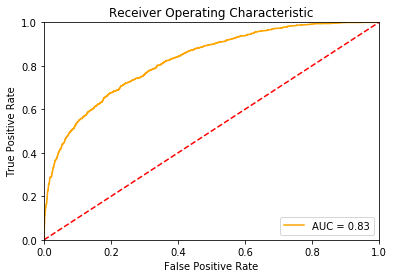

In [47]:
nn_mod = MLPClassifier(hidden_layer_sizes = (100,100),
                       max_iter=300,
                      beta_1=best_estimator_.beta_1,
                      beta_2=best_estimator_.beta_2)
nn_mod.fit(X_train, y_train)
probs = nn_mod.predict_proba(X_test)
print_metrics(y_test, scoring_model(probs, 0.5))
plot_auc(y_test, probs)

# Support Vector Machine

In [48]:
# Define a SVM model
svc_clf = svm.SVC(class_weight = {0:0.33, 1:0.67})

In [51]:
Labels = Labels.reshape(Labels.shape[0],)
# nested cross validation
param_grid = {"C": [1, 10, 100, 1000], 
              "gamma":[1.0/50.0, 1.0/200.0, 1.0/500.0, 1.0/1000.0]}
n_splits = 5
svc_clf, best_estimator_ = nested_cross_val(svc_clf, param_grid, Features, Labels, n_splits)
print('best estimator:')
print(best_estimator_.C, best_estimator_.gamma)
# 100  0.02

KeyboardInterrupt: 

### Use the best parameters to test the performance

In [ ]:
svc_mod = svm.SVC(class_weight='balanced',
                 C=best_estimator_.C,
                 gamma=best_estimator_.gamma,
                 probability=True)
svc_mod.fit(X_train, y_train)
probs = svc_mod.predict_proba(X_test)
print_metrics(y_test, scoring_model(probs, 0.5))
plot_auc(y_test, probs)